In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gaurav1004","key":"b867e5d4043eb2047e5860e50efe55d3"}'}

In [3]:
!mkdir ~/.kaggle


In [4]:
!mv kaggle.json ~/.kaggle/


In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
#!/bin/bash
!kaggle datasets download sartajbhuvaji/brain-tumor-classification-mri

Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
License(s): MIT
 99% 86.0M/86.8M [00:05<00:00, 24.3MB/s]
100% 86.8M/86.8M [00:05<00:00, 17.9MB/s]


In [7]:
!unzip brain-tumor-classification-mri.zip

Archive:  brain-tumor-classification-mri.zip
  inflating: Testing/glioma_tumor/image(1).jpg  
  inflating: Testing/glioma_tumor/image(10).jpg  
  inflating: Testing/glioma_tumor/image(100).jpg  
  inflating: Testing/glioma_tumor/image(11).jpg  
  inflating: Testing/glioma_tumor/image(12).jpg  
  inflating: Testing/glioma_tumor/image(13).jpg  
  inflating: Testing/glioma_tumor/image(14).jpg  
  inflating: Testing/glioma_tumor/image(15).jpg  
  inflating: Testing/glioma_tumor/image(16).jpg  
  inflating: Testing/glioma_tumor/image(17).jpg  
  inflating: Testing/glioma_tumor/image(18).jpg  
  inflating: Testing/glioma_tumor/image(19).jpg  
  inflating: Testing/glioma_tumor/image(2).jpg  
  inflating: Testing/glioma_tumor/image(20).jpg  
  inflating: Testing/glioma_tumor/image(21).jpg  
  inflating: Testing/glioma_tumor/image(22).jpg  
  inflating: Testing/glioma_tumor/image(23).jpg  
  inflating: Testing/glioma_tumor/image(24).jpg  
  inflating: Testing/glioma_tumor/image(25).jpg  
  infl

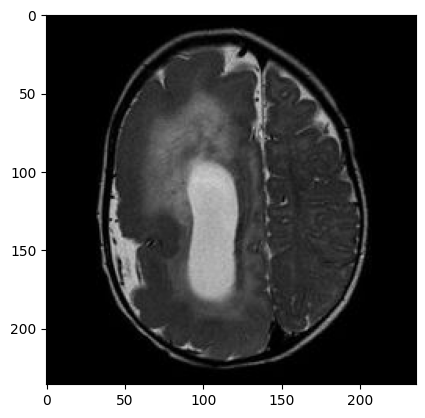

In [8]:
import cv2
import matplotlib.pyplot as plt
image = cv2.imread(r'/content/Testing/glioma_tumor/image(49).jpg')
plt.imshow(image)
plt.show()
# cv2.__version__

In [9]:
image.shape

(236, 236, 3)

In [10]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
train_val_dataset = image_dataset_from_directory(
    "/content/Training",
    validation_split=0.2,  # 80% training, 20% validation
    subset="training",  # Or "validation" for the validation set
    seed=123,
    image_size=(160, 160),
    batch_size=32
)

# Use a separate test folder directly for testing
test_dataset = image_dataset_from_directory(
    "/content/Testing",
    image_size=(160, 160),
    batch_size=32
)

Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Found 394 files belonging to 4 classes.


In [11]:
print(train_val_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [12]:
!pip install wandb


In [13]:
# Paths to data directories
train_dir = "/content/Training"  # Replace with the path to the train directory
test_dir = "/content/Testing"    # Replace with the path to the test directory

# Load dataset
train_val_split = 0.25  # 15% for validation, 75% for training
batch_size = 10
img_size = (236, 236)

# Training dataset (with programmatically created validation split)
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# Split training data into train and validation datasets (e.g., 75% train, 15% validation)
val_split = 0.15
train_batches = int(len(train_dataset) * (1 - val_split))

train_dataset = train_dataset.take(train_batches)
val_dataset = train_dataset.skip(train_batches)

# Test dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# Normalize the pixel values to [-1, 1]
def preprocess(image, label):
    image = tf.image.per_image_standardization(image)
    label = tf.one_hot(label, depth=4)  # 4 classes
    return image, label

# Normalize and preprocess the datasets
train_dataset = train_dataset.map(preprocess).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(preprocess).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess).cache().prefetch(buffer_size=tf.data.AUTOTUNE)


Found 2870 files belonging to 4 classes.
Found 394 files belonging to 4 classes.


In [14]:
pip install --upgrade wandb


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 52.6 MB/s eta 0:00:00
  Attempting uninstall: wandb
    Found existing installation: wandb 0.19.7
    Uninstalling wandb-0.19.7:
      Successfully uninstalled wandb-0.19.7


In [21]:
import wandb
import tensorflow as tf
from wandb.integration.keras import WandbCallback

In [ ]:
import wandb
from wandb.integration.keras import WandbCallback
from tensorflow.keras import layers, models
from keras import regularizers

# Initialize W&B with configuration
wandb.init(
    project="tumor-detection",
    config={
        "model": "Multi-layer CNN",
        "input_shape": (236, 236, 3),
        "num_classes": 4,
        "learning_rate": 0.0001,
        "batch_size": 32,
        "epochs": 14,
        "optimizer": "Adam",
        "loss_function": "categorical_crossentropy",
        "metrics": ["accuracy", "precision", "recall"],
    }
)

# Get the config object
config = wandb.config

# Define Multi-layer CNN model
def create_multilayer_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=config.input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(config.num_classes, activation='softmax')  # 4 classes
    ])
    return model

# Compile the Multi-layer CNN
multilayer_cnn = create_multilayer_cnn()
multilayer_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate),
    loss=config.loss_function,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Callbacks including W&B
callbacks = [
    # WandbCallback(),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", patience=3, factor=0.3, min_lr=1e-5)
]

# # Train the Multi-layer CNN
# multilayer_cnn.fit(
#     train_dataset,
#     validation_data=val_dataset,
#     epochs=config.epochs,
#     batch_size=config.batch_size,
#     callbacks=[WandbCallback()]
# )


# Define Transfer Learning Model
def create_transfer_model(base_model):
    base_model.trainable = False
    inputs = tf.keras.Input(shape=(236, 236, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.05)(x)
    outputs = layers.Dense(4, activation='softmax', kernel_regularizer=regularizers.l2(0.1))(x)
    model = models.Model(inputs, outputs)
    return model

# Base Models: InceptionV3, EfficientNetB4, VGG16, VGG19
base_models = {
    "InceptionV3": tf.keras.applications.InceptionV3(weights="imagenet", include_top=False),
    "EfficientNetB4": tf.keras.applications.EfficientNetB4(weights="imagenet", include_top=False),
    "VGG16": tf.keras.applications.VGG16(weights="imagenet", include_top=False),
    "VGG19": tf.keras.applications.VGG19(weights="imagenet", include_top=False)
}

# Train and evaluate each transfer learning model
for model_name, base_model in base_models.items():
    print(f"Training {model_name}...")
    transfer_model = create_transfer_model(base_model)
    transfer_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    # Train the transfer learning model
    transfer_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=14,
        batch_size=batch_size,
        callbacks=callbacks
    )

    # Evaluate on the test set
    test_results = transfer_model.evaluate(test_dataset)
    print(f"Test Results for {model_name}: {test_results}")
    wandb.log({"test_results": dict(zip(transfer_model.metrics_names, test_results))})

wandb.finish()


Training InceptionV3...
Epoch 1/14
243/243 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step - accuracy: 0.3706 - loss: 2.0752 - precision_4: 0.4301 - recall_4: 0.1239 - learning_rate: 1.0000e-04
Epoch 2/14
  3/243 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.4333 - loss: 1.7641 - precision_4: 0.4135 - recall_4: 0.1722

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


243/243 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - accuracy: 0.6314 - loss: 1.5781 - precision_4: 0.7769 - recall_4: 0.3694 - learning_rate: 1.0000e-04
Epoch 3/14
243/243 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.6834 - loss: 1.3686 - precision_4: 0.7934 - recall_4: 0.4998 - learning_rate: 1.0000e-04
Epoch 4/14
243/243 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.7354 - loss: 1.2203 - precision_4: 0.8249 - recall_4: 0.5756 - learning_rate: 1.0000e-04
Epoch 5/14
243/243 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7515 - loss: 1.1141 - precision_4: 0.8278 - recall_4: 0.6109 - learning_rate: 1.0000e-04
Epoch 6/14
243/243 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.7664 - loss: 1.0349 - precision_4: 0.8501 - recall_4: 0.6467 - learning_rate: 1.0000e-04
Epoch 7/14
243/243 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7779 - loss: 0.9679 - precision_4: 0.8477 - recall_4: 0.6679 - learning_rate: 1.0000e-04
Epoch 8/14
243/243 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7872 -

In [ ]:
print(f"TensorFlow version: {tf.__version__}")
print(f"Wandb version: {wandb.__version__}")